Latest pytorch broke the dataloader, need to downgrade:
`conda install pytorch=1.3 torchvision=0.4.2 cudatoolkit=10.1 -c pytorch`

https://forums.fast.ai/t/fastai-v2-chat/53518/638
    
Yes. Since my datasets are in portuguese, I used the multilingual models from transformers (Bert multilingual, Xlm 17 and Xlm-Roberta), using fastai2 as the framework for data, learner and training loop.

I am getting better results with AWD-LSTM with 15k tokens Sentencepiece and Label Smoothing Crossentropy Loss for the Language model finetuning and Classifier.

I suspect the 15k tokens for SP, inspired on the MultiFIT paper (I was using 32k before and getting worse results), the Label Smoothing for the domain finetune and classification, and the new pad_input_chunk (fastai2) for the padding in the classification are the main suspects for the boost.

I am not using the backward model yet, which I suspect would improve further the results.

NEXT POST: 

For training the language models on wikipedia, I used almost exactly the same parameters @pierreguillou used in his notebooks (https://github.com/piegu/language-models/blob/master/lm3-portuguese.ipynb 6), but i got better results with LSTM than with QRNN. I kept the same number of tokens for the entire corpora, the same wd values, dropouts, number of epochs as his. The only different parameter is that I used the default LSTM config:

{‘emb_sz’: 400,
‘n_hid’: 1152,
‘n_layers’: 3,
‘pad_token’: 1,
‘qrnn’: False,
‘bidir’: False,
‘output_p’: 0.1,
‘hidden_p’: 0.15,
‘input_p’: 0.25,
‘embed_p’: 0.02,
‘weight_p’: 0.2,
‘tie_weights’: True,
‘out_bias’: True}

For clarification, I trained the portuguese Language Model using fastai v1. And then finetuned to the domain corpora and trained the classification model using fastai2. For the moms in fastai2, I always used moms=(0.8,0.7,0.8) and the pad_input_chunk for the classification dataloader. For the rest, I used the same parameters as his TCU classification notebook.

Now I am trying to adapt my code to finetune (using fastai2) a backward version of an analog protuguese Language Model I trained using fastai v1.


NEXT POST:

def backwards(tokens):
    return tokens.flip(0)

tfms = [attrgetter("text"), Tokenizer(tokenizer=sp), Numericalize(vocab), backwards]
splits = RandomSplitter(valid_pct=0.1, seed=42)(df)

dsrc = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

REPLY: 

Nice and easy, I like it!

Edit: Not too sure it works well with the pad_input_chunks directly, I think you might need to do it the other way (so pad_first=False) to make sure it works as intended.

### fastai wiki training scripts
https://github.com/fastai/fastai/tree/master/courses/dl2/imdb_scripts

In [1]:
%reload_ext autoreload
%autoreload 2

from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *
import gc

from tqdm import tqdm
import wandb
#from wandb.fastai import WandbCallback
from fastai2.callback.wandb import *

from datetime import date
#wandb.init(project="kaggle_google_question_wandb")

# Load data

In [2]:
lm_data = pd.read_feather(f'data/lm_data_2020-02-04.ftr')

print(f'Nans frac: {lm_data.isna().doc.sum() / len(lm_data)}')
print(f'Total rows : {len(lm_data)/1000000}M')
print(f'Total character count : {lm_data.char_count.sum()/1000000}M')
print()
print(lm_data.groupby('source').sum() / lm_data.char_count.sum())
print()
lm_data.head()

Nans frac: 0.0
Total rows : 0.207581M
Total character count : 846.918289M

             char_count
source                 
stacksample    0.173837
tf2qa          0.181378
wiki103        0.644786



,doc,source,char_count
0,"xxars xxh1s Valkyria Chronicles III xxh1e xxnpg Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the "" Nameless "" , a penal military unit...",wiki103,21104
1,"xxars xxh1s Tower Building of the Little Rock Arsenal xxh1e xxnpg The Tower Building of the Little Rock Arsenal , also known as U.S. Arsenal Building , is a building located in MacArthur Park in downtown Little Rock , Arkansas . Built in 1840 , it was part of Little Rock 's first military installation . Since its decommissioning , The Tower Building has housed two museums . It was home to the Arkansas Museum of Natural History and Antiquities from 1942 to 1997 and the MacArthur Museum of Arkansas Military History since 2001 . It has also been the headquarters of the Little Rock Æsthetic ...",wiki103,21870
2,"xxars xxh1s Cicely Mary Barker xxh1e xxnpg Cicely Mary Barker ( 28 June 1895 – 16 February 1973 ) was an English illustrator best known for a series of fantasy illustrations depicting fairies and flowers . Barker 's art education began in girlhood with correspondence courses and instruction at the Croydon School of Art . Her earliest professional work included greeting cards and juvenile magazine illustrations , and her first book , Flower Fairies of the Spring , was published in 1923 . Similar books were published in the following decades . xxnpg Barker was a devout Anglican , and dona...",wiki103,16713
3,"xxars xxh1s Gambia women 's national football team xxh1e xxnpg The Gambia women 's national football team represents the Gambia in international football competition . The team , however , has not competed in a match recognised by FIFA , the sport 's international governing body , despite that organised women 's football has been played in the country since 1998 . The Gambia has two youth teams , an under @-@ 17 side that has competed in FIFA U @-@ 17 Women 's World Cup qualifiers , and an under @-@ 19 side that withdrew from regional qualifiers for an under @-@ 19 World Cup . The develo...",wiki103,3735
4,"xxars xxh1s Plain maskray xxh1e xxnpg The plain maskray or brown stingray ( Neotrygon annotata ) is a species of stingray in the family Dasyatidae . It is found in shallow , soft @-@ bottomed habitats off northern Australia . Reaching 24 cm ( 9 @.@ 4 in ) in width , this species has a diamond @-@ shaped , grayish green pectoral fin disc . Its short , whip @-@ like tail has alternating black and white bands and fin folds above and below . There are short rows of thorns on the back and the base of the tail , but otherwise the skin is smooth . While this species possesses the dark mask @-@ ...",wiki103,7085


### Reduce data size

In [3]:
lm_data['word_count'] = lm_data['doc'].str.count(' ') + 1
print(f'There are roughly {lm_data["word_count"].sum()/1000000}M words')

There are roughly 171.141752M words


In [4]:
lm_data = lm_data.sample(frac=0.65).copy()

### Create Train/Val split

In [5]:
train_idx = int(round(len(lm_data) * 0.85,0))

print(train_idx)
# Shuffle data
lm_data = lm_data.sample(frac=1)

trn_df = lm_data.iloc[:train_idx, :].copy()
val_df = lm_data.iloc[train_idx:, :].copy()
all_df = pd.concat([trn_df,val_df])

print(f'Train len : {len(trn_df)}')
print(trn_df.groupby('source').sum() / trn_df.char_count.sum())
print()

print(f'Val len : {len(val_df)}')
print(val_df.groupby('source').sum() / val_df.char_count.sum())

# Delete original dataset
del lm_data
gc.collect()

114689
Train len : 114689
             char_count  word_count
source                             
stacksample    0.174694    0.034021
tf2qa          0.178374    0.045453
wiki103        0.646932    0.122461

Val len : 20239
             char_count  word_count
source                             
stacksample    0.172497    0.033592
tf2qa          0.191655    0.049174
wiki103        0.635848    0.120314


0

#### Grab small sample

In [6]:
# n_train = 500
# n_val = 75
# trn_df = trn_df.iloc[:n_train,:].copy()
# val_df = val_df.iloc[:n_val,:].copy()

# all_df = pd.concat([trn_df,val_df])

## Set up Tokenizer, Dataset and Dataloader

In [10]:
def mmg_get_tokenizer(tok_func=SentencePieceTokenizer, **kwargs):
    sign = inspect.signature(tok_func)    
    for k in list(kwargs.keys()):
        # OLD: if not k in sign: kwargs.pop(k)
        if not k in str(sign): kwargs.pop(k)        
    return tok_func(**kwargs)
    
class mmgTokenizer(Tokenizer):
    @classmethod
    @delegates(tokenize_df, keep=True)
    def from_df(cls, text_cols, tok_func=SpacyTokenizer, **kwargs):
        # Custom mmg_get_tokenizer function here:
        res = cls(mmg_get_tokenizer(tok_func, **kwargs), mode='df')
        res.text_cols,res.kwargs,res.train_setup = text_cols,merge({'tok_func': tok_func}, kwargs),False
        return res
    
class mmgSentencePieceTokenizer(SentencePieceTokenizer):  
    def train(self, raw_text_path):
        "Train a sentencepiece tokenizer on `texts` and save it in `path/tmp_dir`"
        from sentencepiece import SentencePieceTrainer
        vocab_sz = self._get_vocab_sz(raw_text_path) if self.vocab_sz is None else self.vocab_sz
        print(f'vocab_sz is {vocab_sz}')
        
        spec_tokens = ['\u2581'+s for s in self.special_toks]
        
        #print(spec_tokens)
        SentencePieceTrainer.Train(" ".join([
            f"--input={raw_text_path} --vocab_size={vocab_sz} --model_prefix={self.cache_dir/'spm'}",
            f"--character_coverage={self.char_coverage} --model_type={self.model_type}",
            f"--unk_id={len(spec_tokens)} --pad_id=-1 --bos_id=-1 --eos_id=-1",
            f"--user_defined_symbols={','.join(spec_tokens)}"   ,   
            "--hard_vocab_limit=false"   # MORGAN ADDED HERE AS PER https://github.com/google/sentencepiece/issues/226
        ]))
        raw_text_path.unlink()
        return self.cache_dir/'spm.model'
    
    
    def setup(self, items, rules):
        #print('fastai rules used:')
        #for r in rules:
            #print(r)
            #print(inspect.signature(r)) 

        if self.tok is not None: return {'sp_model': self.sp_model}
        raw_text_path = self.cache_dir/'texts.out'
        with open(raw_text_path, 'w') as f:
            for t in progress_bar(maps(*rules, items), total=len(items), leave=False):
                f.write(f'{t}\n')
        print(raw_text_path)
        return {'sp_model': self.train(raw_text_path)}

#### Sentencepiece notes
\u2581 = _

### Addition Special Tokens besides the fastai ones
'xxnpg' : New Paragraph

'xxqts' : Question Title Start

'xxqte' : Question Title End

'xxqbs' : Question Body Start

'xxqbe' : Question Body End

'xxans' : Answer Body Start

'xxane' : Answer Body End

'xxars' : Article Start

'xxare' : Article End

'xxh1s' : Header 1 Start

'xxh2s' : 

'xxh3s' :

'xxh4s' : 

'xxh5s' :

'xxh1e' : Header 1 End

'xxh2e' :

'xxh3e' : 

'xxh4e' :

'xxh5e' :

'xxcls' : Class/Category/Tag

In [8]:
additional_special_toks = ['xxnpg', 'xxqts', 'xxqte', 'xxqbs','xxqbe','xxans','xxane','xxars','xxare',
                'xxh1s','xxh2s','xxh3s','xxh4s','xxh5s',
                'xxh1e','xxh2e','xxh3e','xxh4e','xxh5e']

all_special_toks = defaults.text_spec_tok + additional_special_toks
all_special_toks

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'xxnpg',
 'xxqts',
 'xxqte',
 'xxqbs',
 'xxqbe',
 'xxans',
 'xxane',
 'xxars',
 'xxare',
 'xxh1s',
 'xxh2s',
 'xxh3s',
 'xxh4s',
 'xxh5s',
 'xxh1e',
 'xxh2e',
 'xxh3e',
 'xxh4e',
 'xxh5e']

### Create dataloaders

In [11]:
tok_fn = mmgTokenizer.from_df(text_cols='doc', res_col_name='doc',
                     tok_func=mmgSentencePieceTokenizer, 
                     model_type='bpe', 
                     special_toks=all_special_toks, 
                     max_vocab_sz=20000
                    ) 

In [15]:
bs=128
sl = 72

splits = [list(range_of(trn_df)), list(range(len(trn_df), len(all_df)))]
tfms = [attrgetter('doc'), tok_fn, Numericalize()]   # Load pretrained model's vocab
## ERROR: https://github.com/google/sentencepiece/issues/297
## https://github.com/google/sentencepiece/issues/226

lmdsets = Datasets(all_df, [tfms], splits=splits, dl_type=LMDataLoader)

In [14]:
lmdls = lmdsets.dataloaders(bs=bs, seq_len=sl, device='cuda')

In [16]:
lmdls.show_batch()

,text,text_
0,"▁xxbos ▁xxqts ▁xxmaj ▁how ▁to ▁enable ▁datagridview ▁sorting ▁when ▁user ▁clicks ▁on ▁the ▁column ▁header ? ▁xxqte ▁xxqbs ▁i ▁have ▁a ▁datagridview ▁on ▁my ▁form ▁and ▁i ▁populate ▁it ▁with ▁this : ▁xxnpg ▁xxnpg ▁datagridview 1. datasource ▁= ▁students . select ( s ▁=> ▁new ▁{ ▁xxup ▁id ▁= ▁s . student id , ▁xxup ▁r ude ▁= ▁s . r ude , ▁xxmaj ▁nom bre ▁= ▁s . name , ▁xxmaj","▁xxqts ▁xxmaj ▁how ▁to ▁enable ▁datagridview ▁sorting ▁when ▁user ▁clicks ▁on ▁the ▁column ▁header ? ▁xxqte ▁xxqbs ▁i ▁have ▁a ▁datagridview ▁on ▁my ▁form ▁and ▁i ▁populate ▁it ▁with ▁this : ▁xxnpg ▁xxnpg ▁datagridview 1. datasource ▁= ▁students . select ( s ▁=> ▁new ▁{ ▁xxup ▁id ▁= ▁s . student id , ▁xxup ▁r ude ▁= ▁s . r ude , ▁xxmaj ▁nom bre ▁= ▁s . name , ▁xxmaj ▁a"
1,"▁is ▁the ▁final ▁solution ▁i ▁used ▁after ▁taking ▁@ andy ' s ▁code , ▁and ▁modifying ▁it ▁a ▁bit . ▁xxnpg ▁xxnpg ▁function ▁range array tostring ($ range array , ▁$ max ▁= ▁99 ) ▁{ ▁xxnpg ▁sort ($ range array ); ▁xxnpg ▁$ first ▁= ▁$ last ▁= ▁null ; ▁xxnpg ▁$ output ▁= ▁array (); ▁xxnpg ▁xxnpg ▁foreach ▁($ range array ▁as ▁$ item ) ▁{ ▁xxnpg ▁if ▁($ first","▁the ▁final ▁solution ▁i ▁used ▁after ▁taking ▁@ andy ' s ▁code , ▁and ▁modifying ▁it ▁a ▁bit . ▁xxnpg ▁xxnpg ▁function ▁range array tostring ($ range array , ▁$ max ▁= ▁99 ) ▁{ ▁xxnpg ▁sort ($ range array ); ▁xxnpg ▁$ first ▁= ▁$ last ▁= ▁null ; ▁xxnpg ▁$ output ▁= ▁array (); ▁xxnpg ▁xxnpg ▁foreach ▁($ range array ▁as ▁$ item ) ▁{ ▁xxnpg ▁if ▁($ first ▁xxrep"
2,"▁ark ans an ▁xxmaj ▁ark ans aw yer ▁, ▁xxmaj ▁ark ie ▁xxmaj ▁california ▁xxmaj ▁californ ian ▁xxmaj ▁californ io ▁( ▁arch aic ▁) ▁xxmaj ▁colorado ▁xxmaj ▁color ad an ▁xxmaj ▁colorado an ▁( ▁arch aic ▁) ▁xxmaj ▁connecticut ▁xxmaj ▁connecticut er ▁xxmaj ▁connect ic ot ian ▁, ▁xxmaj ▁connecticut ens ian ▁, ▁xxmaj ▁nut me g ▁, ▁xxmaj ▁nut me g ger ▁xxmaj ▁delaware ▁xxmaj ▁delaware an ▁xxmaj ▁blue ▁xxmaj ▁hen","ans an ▁xxmaj ▁ark ans aw yer ▁, ▁xxmaj ▁ark ie ▁xxmaj ▁california ▁xxmaj ▁californ ian ▁xxmaj ▁californ io ▁( ▁arch aic ▁) ▁xxmaj ▁colorado ▁xxmaj ▁color ad an ▁xxmaj ▁colorado an ▁( ▁arch aic ▁) ▁xxmaj ▁connecticut ▁xxmaj ▁connecticut er ▁xxmaj ▁connect ic ot ian ▁, ▁xxmaj ▁connecticut ens ian ▁, ▁xxmaj ▁nut me g ▁, ▁xxmaj ▁nut me g ger ▁xxmaj ▁delaware ▁xxmaj ▁delaware an ▁xxmaj ▁blue ▁xxmaj ▁hen ▁'"
3,"▁the ▁night cl ub ▁is ▁prof itable ▁; ▁the ▁xxmaj ▁chinese ▁opera ▁is ▁not ▁. ▁xxmaj ▁me i - li ▁joins ▁the ▁opera ▁company ▁( ▁"" ▁i ▁xxmaj ▁am ▁xxmaj ▁going ▁to ▁xxmaj ▁like ▁xxmaj ▁it ▁xxmaj ▁here ▁"" ▁) ▁and ▁is ▁soon ▁attracted ▁to ▁the ▁ind if ferent ▁xxmaj ▁ta ▁, ▁who ▁fav ors ▁xxmaj ▁linda ▁. ▁xxmaj ▁me i - li ▁is ▁fasc inated ▁by ▁xxmaj ▁linda ▁, ▁who ▁ur","▁night cl ub ▁is ▁prof itable ▁; ▁the ▁xxmaj ▁chinese ▁opera ▁is ▁not ▁. ▁xxmaj ▁me i - li ▁joins ▁the ▁opera ▁company ▁( ▁"" ▁i ▁xxmaj ▁am ▁xxmaj ▁going ▁to ▁xxmaj ▁like ▁xxmaj ▁it ▁xxmaj ▁here ▁"" ▁) ▁and ▁is ▁soon ▁attracted ▁to ▁the ▁ind if ferent ▁xxmaj ▁ta ▁, ▁who ▁fav ors ▁xxmaj ▁linda ▁. ▁xxmaj ▁me i - li ▁is ▁fasc inated ▁by ▁xxmaj ▁linda ▁, ▁who ▁ur ges"
4,"▁the ▁xxmaj ▁scr anton ▁xxmaj ▁str ang ler ▁trial ▁, ▁leading ▁the ▁corporate ▁office ▁to ▁send ▁xxmaj ▁holly ▁xxmaj ▁fl ax ▁( ▁xxmaj ▁amy ▁xxmaj ▁ryan ▁) ▁to ▁cover ▁for ▁him ▁. ▁xxmaj ▁michael ▁forces ▁xxmaj ▁pam ▁xxmaj ▁hal pert ▁( ▁xxmaj ▁jenna ▁xxmaj ▁fis cher ▁) ▁to ▁plan ▁a ▁second ▁, ▁class ier ▁xxmaj ▁christmas ▁party ▁on ▁the ▁day ▁xxmaj ▁holly ▁returns ▁to ▁xxmaj ▁scr anton ▁. ▁xxmaj ▁michael ▁wel comes","▁xxmaj ▁scr anton ▁xxmaj ▁str ang ler ▁trial ▁, ▁leading ▁the ▁corporate ▁office ▁to ▁send ▁xxmaj ▁holly ▁xxmaj ▁fl ax ▁( ▁xxmaj ▁amy ▁xxmaj ▁ryan ▁) ▁to ▁cover ▁for ▁him ▁. ▁xxmaj ▁michael ▁forces ▁xxmaj ▁pam ▁xxmaj ▁hal pert ▁( ▁xxmaj ▁jenna ▁xxmaj ▁fis cher ▁) ▁to ▁plan ▁a ▁second ▁, ▁class ier ▁xxmaj ▁christmas ▁party ▁on ▁the ▁day ▁xxmaj ▁holly ▁returns ▁to ▁xxmaj ▁scr anton ▁. ▁xxmaj ▁michael ▁wel comes ▁xxmaj"
5,▁world ▁' s ▁xxmaj ▁best ▁xxmaj ▁cola ▁! ▁'' ▁`` ▁xxmaj ▁g att ai ▁- ▁xxmaj ▁w aza ▁xxmaj ▁s ak ure ts

# AWD_LSTM - LM Model

The main idea of the article is to use a RNN with dropout everywhere, but in an intelligent way. There is a difference with the usual dropout, which is why you’ll see a RNNDropout module: we zero things, as is usual in dropout, but we always zero the same thing according to the sequence dimension (which is the first dimension in pytorch). This ensures consistency when updating the hidden state through the whole sentences/articles.

This being given, there are a total four different dropouts in the encoder of the AWD-LSTM:

the first one, embedding dropout, is applied when we look the ids of our tokens inside the embedding matrix (to transform them from numbers to a vector of float). We zero some lines of it, so random ids are sent to a vector of zeros instead of being sent to their embedding vector. This is the `embed_p` parameter.

the second one, input dropout, is applied to the result of the embedding with dropout. We forget random pieces of the embedding matrix (but as stated in the last paragraph, the same ones in the sequence dimension). This is the `input_p` parameter.

the third one is the weight dropout. It’s the trickiest to implement as we randomly replace by 0s some weights of the hidden-to-hidden matrix inside the RNN: this needs to be done in a way that ensure the gradients are still computed and the initial weights still updated. This is the `weight_p` parameter.


the fourth one is the hidden dropout. It’s applied to the output of one of the layers of the RNN before it’s used as input of the next layer (again same coordinates are zeroed in the sequence dimension). It isn’t applied to the last output (which will get its own dropout in the decoder).This is the `hidden_p` parameter.

The other attributes are vocab_sz for the number of tokens in your vocabulary, emb_sz for the embedding size, n_hid for the hidden size of your inner LSTMs (or QRNNs), n_layers the number of layers and pad_token for the index of an eventual padding token (1 by default in fastai).

{‘emb_sz’: 400, ‘n_hid’: 1152, ‘n_layers’: 3, ‘pad_token’: 1, ‘qrnn’: False, ‘bidir’: False, ‘output_p’: 0.1, ‘hidden_p’: 0.15, ‘input_p’: 0.25, ‘embed_p’: 0.02, 
 ‘weight_p’: 0.2, ‘tie_weights’: True, ‘out_bias’: True}

In [17]:
awd_lstm_lm_config

{'emb_sz': 400,
 'n_hid': 1152,
 'n_layers': 3,
 'pad_token': 1,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [32]:
large_config = awd_lstm_lm_config.copy()
large_config['n_layers'] = 4
large_config['n_hid'] = 1500
large_config['emb_sz'] = 500
#config['input_p'] = 0.07
# # From docs:
# config.update({'input_p': 0.6, 'output_p': 0.4, 'weight_p': 0.5, 'embed_p': 0.1, 'hidden_p': 0.2})
# config

In [49]:
#opt_func = partial(Adam, wd=0.1, eps=1e-7)

from ranger import Ranger

#optar=partial(RangerQH,nus=(.70,1.0),betas=(0.92, 0.999),eps=1e-6)
def optfunc(p, lr=defaults.lr): return Lookahead(RAdam(p, lr=lr))

cb_funcs = [MixedPrecision(clip=0.1), ModelReseter, RNNRegularizer(alpha=2, beta=1)]

In [51]:
lmmodel = get_language_model(AWD_LSTM, vocab_sz=len(lmdls.vocab), config=large_config)

In [52]:
lmlearn = Learner(dls=lmdls, model=lmmodel, 
                  loss_func=CrossEntropyLossFlat(), 
                opt_func=optfunc, 
                cbs=[MixedPrecision(clip=0.1), ModelReseter, RNNRegularizer(alpha=2, beta=1),SaveModelCallback()],
                metrics=[accuracy, Perplexity()])

In [45]:
# lm_model = get_language_model(AWD_LSTM, vocab_sz=len(lmdls.vocab), config=awd_lstm_lm_config)

# lm_cbs = [MixedPrecision(clip=0.1), ModelReseter, RNNRegularizer(alpha=2, beta=1)]

# lm_learn = Learner(dls=lmdls, model=lm_model, loss_func=CrossEntropyLossFlat(), 
#                 opt_func=optfunc, cbs=cb_funcs,
#                 metrics=[accuracy, Perplexity()])

In [53]:
lmlearn.show_training_loop()

Start Fit
   - begin_fit      : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback, MixedPrecision]
  Start Epoch Loop
     - begin_epoch    : [Recorder, ProgressCallback]
    Start Train
       - begin_train    : [TrainEvalCallback, Recorder, ProgressCallback, ModelReseter]
      Start Batch Loop
         - begin_batch    : [MixedPrecision]
         - after_pred     : [RNNRegularizer, MixedPrecision]
         - after_loss     : [RNNRegularizer, MixedPrecision]
         - after_backward : [MixedPrecision]
         - after_step     : [MixedPrecision]
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - begin_validate : [TrainEvalCallback, Recorder, ProgressCallback, ModelReseter]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
  

(0.05248074531555176, 0.03981071710586548)

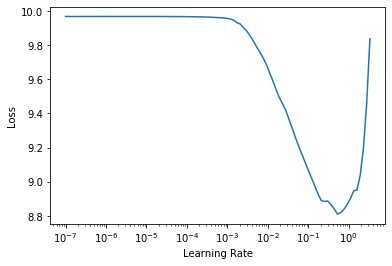

In [55]:
#learn.model.cuda()
lmlearn.lr_find(suggestions=True)

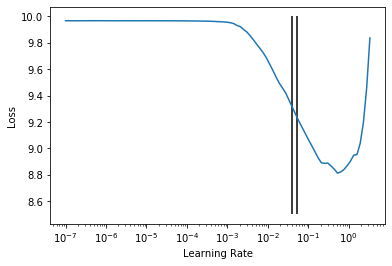

In [57]:
lmlearn.recorder.plot_lr_find()
plt.vlines(0.05248, 8.5, 10)
plt.vlines(0.039810, 8.5, 10)

In [61]:
# fit_flat_cos(self:Learner, n_epoch, lr=None, div_final=1e5, pct_start=0.75, wd=defaults.wd,
#                  cbs=None, reset_opt=False):
# moms=(0.8,0.7,0.8)
lmlearn.fit_flat_cos(7, 2e-3, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,nan,3.826343,0.343878,45.894409,2:14:03
1,nan,3.540510,0.372675,34.484493,2:14:20
2,nan,3.412912,0.387074,30.353510,2:16:14
3,nan,3.330651,0.396612,27.956524,2:13:48
4,nan,3.253711,0.405923,25.886219,2:13:58
5,nan,3.187689,0.415116,24.232351,2:14:55
6,nan,3.167228,0.418152,23.741570,2:14:00


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [62]:
lmlearn.save(f'lm_large_7e_2e-3_ffc_{date.today()}')

In [63]:
with open(f'lm_large_7e_2e-3_ffc_{date.today()}_vocab', 'wb') as f:
    pickle.dump(lmdls.vocab, f)

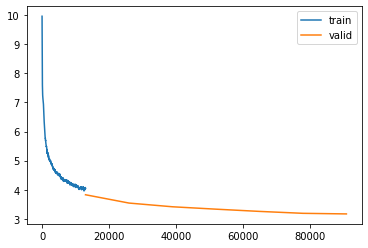

In [64]:
lmlearn.recorder.plot_loss()

In [65]:
lm_learn.recorder.plot_sched()

AttributeError: hps